### Objective - Apply LSTM on Amazon Fine Food Reviews to do a semantic analysis on reviews.

In [5]:

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import nltk
import string
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
from matplotlib import pyplot as plt
import seaborn as sns
import keras
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import sqlite3
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn import cross_validation

from sklearn.model_selection import train_test_split

Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


#### Loading Data 

In [6]:
# using the SQLite Table to read data.
con = sqlite3.connect("/Users/mohdsaquib/Documents/data/database.sqlite") 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [7]:
filtered_data.shape

(525814, 10)

In [8]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


### Preprocessing and Cleaning of Data

In [9]:
##Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

#Removing the anamolies
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

#Preprocessing
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    # sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
## Similartly you can do preprocessing for review summary also.
def concatenateSummaryWithText(str1, str2):
    return str1 + ' ' + str2

preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    #sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    # sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())

100%|██████████| 364171/364171 [00:07<00:00, 50238.04it/s]


In [10]:

preprocessed_reviews = list(map(concatenateSummaryWithText, preprocessed_reviews, preprocessed_summary))
final['CleanedText'] = preprocessed_reviews
final['CleanedText'] = final['CleanedText'].astype('str')

#### Splitting the data set into Train and Test

In [11]:
final = final.sort_values('Time',axis= 0,inplace = False , na_position = 'last',ascending = True)
X = final['CleanedText'].values
X = X[:100000]
y = final['Score'].values
y = y[:100000]

In [12]:
X_t, X_test, y_t, y_test = train_test_split(X, y, test_size=0.20, stratify=y, shuffle=True)
X_train, X_cv, y_train, y_cv = train_test_split(X_t, y_t, test_size=0.20, stratify=y_t, shuffle=True)
print("Shape of Input  - Train:", X_train.shape)
print("Shape of Output - Train:", y_train.shape)
print("Shape of Input  - CV   :", X_cv.shape)
print("Shape of Output - CV   :", y_cv.shape)
print("Shape of Input  - Test :", X_test.shape)
print("Shape of Output - Test :", y_test.shape)

Shape of Input  - Train: (64000,)
Shape of Output - Train: (64000,)
Shape of Input  - CV   : (16000,)
Shape of Output - CV   : (16000,)
Shape of Input  - Test : (20000,)
Shape of Output - Test : (20000,)



### Tokenizing the data set 
*This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf.*



In [13]:
##### https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
tokenize = Tokenizer(num_words=5000)
tokenize.fit_on_texts(X_train)

X_train_new = tokenize.texts_to_sequences(X_train)
X_cv_new = tokenize.texts_to_sequences(X_cv)
X_test_new = tokenize.texts_to_sequences(X_test)

print(X_train_new[1])
print(len(X_train_new))

[403, 30, 2, 26, 7, 679, 4, 2995, 166, 4, 378, 18, 307, 122, 3, 307, 490, 269, 466, 81, 184, 5, 69, 15, 8, 1706, 1301, 283, 12, 109, 208, 229, 19, 9, 823, 369, 5, 727, 7, 74, 11, 62, 538, 1396, 30]
64000


### Padding the data set

*Padding helps in giving batch input to model which speeds up the model*

In [14]:
max_review_length = 800
X_train_new = sequence.pad_sequences(X_train_new, maxlen=max_review_length)
X_cv_new = sequence.pad_sequences(X_cv_new, maxlen=max_review_length)
X_test_new = sequence.pad_sequences(X_test_new, maxlen=max_review_length)

print(X_train_new.shape)
print(X_train_new[1])

(64000, 800)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

#### Error Plot function

In [15]:
#### Creating function for error plots
import matplotlib.pyplot as plt
import numpy as np
import time
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()
    
n_epochs = 10
batchsize = 512


### Model 1 - Embedding - LSTM - Output(Sigmoid)


In [16]:
# model 1
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 800, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
m_hist = model.fit(X_train_new, y_train, epochs=n_epochs, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])


Instructions for updating:
Use tf.cast instead.
Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 2098s 33ms/step - loss: 0.3195 - acc: 0.8901 - val_loss: 0.1717 - val_acc: 0.9306
Epoch 2/10
64000/64000 [==============================] - 2092s 33ms/step - loss: 0.1532 - acc: 0.9402 - val_loss: 0.1405 - val_acc: 0.9451
Epoch 3/10
64000/64000 [==============================] - 2060s 32ms/step - loss: 0.1213 - acc: 0.9534 - val_loss: 0.1351 - val_acc: 0.9476
Epoch 4/10
64000/64000 [==============================] - 2050s 32ms/step - loss: 0.1098 - acc: 0.9580 - val_loss: 0.1361 - val_acc: 0.9465
Epoch 5/10
64000/64000 [==============================] - 2046s 32ms/step - loss: 0.1025 - acc: 0.9613 - val_loss: 0.1451 - val_acc: 0.9474
Epoch 6/10
64000/64000 [==============================] - 2042s 32ms/step - loss: 0.0973 - acc: 0.9637 - val_loss: 0.1403 - val_acc: 0.9470
Epoch 7/10
64000/64000 [==============================] - 2038

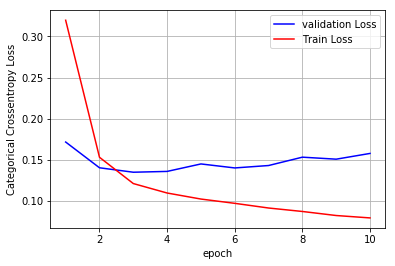

In [18]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

#list of epoch numbers
x = list(range(1, n_epochs+1))
vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Observation- Using only one LSTM layer we get an accuracy of 94.1% which is quite good.
#### From the error plot we can see that Train loss was high during starting epochs and reduce gradually with increase in number of epochs.
#### The validation loss does not show much variation. 

*Using a single LSTM layer we got a good accuracy, lets try 2 layers LSTM and see if it improves any more. *

### Model 2 : Embeddin - 2 LSTM Layer - Output(SIgmoid)

In [19]:
# create the model
embed_vector_length = 32
model = Sequential()
model.add(Embedding(5000, embed_vector_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Printing the Model Summary")
print(model.summary())


Printing the Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 800, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 800, 100)          53200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
## Taking only 5 epochs as model is taking lot of time
m_hist = model.fit(X_train_new, y_train, epochs=5, 
                   batch_size=batchsize, verbose=1, validation_data=(X_cv_new, y_cv))

score = model.evaluate(X_test_new, y_test, batch_size=batchsize)
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 64000 samples, validate on 16000 samples
Epoch 1/5
64000/64000 [==============================] - 4292s 67ms/step - loss: 0.3034 - acc: 0.8937 - val_loss: 0.1805 - val_acc: 0.9272
Epoch 2/5
64000/64000 [==============================] - 4257s 67ms/step - loss: 0.1450 - acc: 0.9440 - val_loss: 0.1326 - val_acc: 0.9484
Epoch 3/5
64000/64000 [==============================] - 4214s 66ms/step - loss: 0.1169 - acc: 0.9559 - val_loss: 0.1326 - val_acc: 0.9480
Epoch 4/5
64000/64000 [==============================] - 4232s 66ms/step - loss: 0.1059 - acc: 0.9602 - val_loss: 0.1337 - val_acc: 0.9491
Epoch 5/5
20000/20000 [==============================] - 433s 22ms/step
Test score: 0.1468111744403839
Test accuracy: 0.94515


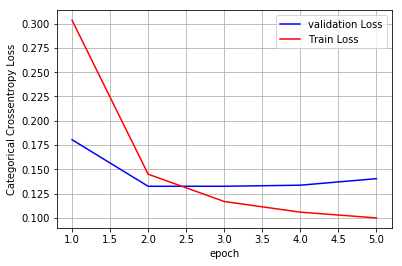

In [21]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Crossentropy Loss')

#list of epoch numbers
x = list(range(1, 6))
vy = m_hist.history['val_loss']
ty = m_hist.history['loss']
plt_dynamic(x, vy, ty, ax)

### Observation-
#### Using 2 LSTM layers improves our accuracy to 94.5% which is better than previous model.
#### From error plot we can see that Train loss at starting epochs was high but gradually decreases with increase in number of epochs.
#### The validaton loss also was little high at starting epoch but then decreases with increase number of epochs and remain constant.

### Conclusion

In [24]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["LSTM Size", "Layers", "Model", "Activation", "Epoch", "Accuracy"]
x.add_row(["100", "1", "LSTM", "Sigmoid", 10, "94.10%"])
x.add_row(["100", "2" ,"LSTM", "Sigmoid", 5, "94.50%"])

print(x)

+-----------+--------+-------+------------+-------+----------+
| LSTM Size | Layers | Model | Activation | Epoch | Accuracy |
+-----------+--------+-------+------------+-------+----------+
|    100    |   1    |  LSTM |  Sigmoid   |   10  |  94.10%  |
|    100    |   2    |  LSTM |  Sigmoid   |   5   |  94.50%  |
+-----------+--------+-------+------------+-------+----------+
